# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Data Analysis
Summarize the characteristics of the dataset.

In [2]:
query_data = QueryData()
clean_data = CleanData()
helpers = Helpers()

# pull boxscore data
boxscores = query_data.query_boxscore_data()
boxscores = clean_data.select_regular_season_games(boxscores)
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [3]:
boxscores['ATTEMPTS'] = boxscores['FGA'] + 0.44*boxscores['FTA']
boxscores['POINTS/ATTEMPT'] = boxscores['PTS']/boxscores['ATTEMPTS']

# Feature Engineering
Create new features from raw data using domain knowlege.

In [4]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='POINTS/ATTEMPT', new_col_name='AVG_POINTS/ATTEMPT',
    weight_col_name='ATTEMPTS'
)

In [5]:
import time
from pyNBA.Data.constants import SEASONS
from nba_api.stats.endpoints import SynergyPlayTypes
from nba_api.stats.library.parameters import PlayTypeNullable
    
play_types = [
    PlayTypeNullable.transition, PlayTypeNullable.pr_ball_handler, PlayTypeNullable.pr_roll_man, PlayTypeNullable.post_up,
    PlayTypeNullable.spot_up, PlayTypeNullable.handoff, PlayTypeNullable.cut, PlayTypeNullable.off_screen,
    PlayTypeNullable.putbacks, PlayTypeNullable.isolation
]

for play_type in play_types:
    player_pbp_data = pd.DataFrame()
    team_pbp_data = pd.DataFrame()
    for season in SEASONS:
        play_type_breakdown = SynergyPlayTypes(season=season, play_type_nullable=play_type, season_type_all_star='Regular Season', player_or_team_abbreviation='P', type_grouping_nullable='Offensive').get_data_frames()[0]
        time.sleep(2.000)

        play_type_breakdown['SEASON'] = season
        play_type_breakdown['PLAYER_ID'] = play_type_breakdown['PLAYER_ID'].apply(lambda x: str(x))
        play_type_breakdown = play_type_breakdown.rename(columns={'TEAM_ABBREVIATION': 'TEAM', 'PLAYER_ID': 'PLAYERID', 'PPP': '{}_PPP'.format(play_type), 'POSS_PCT': '{}_POSS_PCT'.format(play_type)})
        play_type_breakdown = play_type_breakdown[['SEASON', 'PLAYERID', 'TEAM', '{}_PPP'.format(play_type), '{}_POSS_PCT'.format(play_type)]]

        player_pbp_data = player_pbp_data.append(play_type_breakdown)
        
        play_type_breakdown = SynergyPlayTypes(season=season, play_type_nullable=play_type, season_type_all_star='Regular Season', player_or_team_abbreviation='T', type_grouping_nullable='Defensive').get_data_frames()[0]
        time.sleep(2.000)

        play_type_breakdown['SEASON'] = season
        play_type_breakdown = play_type_breakdown.rename(columns={'TEAM_ABBREVIATION': 'OPP_TEAM', 'PPP': '{}_PPP_ALLOWED'.format(play_type), 'POSS_PCT': '{}_POSS_PCT_ALLOWED'.format(play_type)})
        play_type_breakdown = play_type_breakdown[['SEASON', 'OPP_TEAM', '{}_PPP_ALLOWED'.format(play_type), '{}_POSS_PCT_ALLOWED'.format(play_type)]]
        
        team_pbp_data = team_pbp_data.append(play_type_breakdown)
        
        
    boxscores = boxscores.merge(player_pbp_data, on=['SEASON', 'PLAYERID', 'TEAM'], how='left')
    boxscores = boxscores.merge(team_pbp_data, on=['SEASON', 'OPP_TEAM'], how='left')

In [6]:
boxscores['temp1'] = 0
boxscores['temp2'] = 0
for play_type in play_types:
    boxscores['temp1'] += boxscores['{}_POSS_PCT'.format(play_type)].fillna(0)
    boxscores['temp2'] += boxscores['{}_POSS_PCT_ALLOWED'.format(play_type)].fillna(0)
for play_type in play_types:
    boxscores['{}_POSS_PCT'.format(play_type)] = boxscores['{}_POSS_PCT'.format(play_type)]/boxscores['temp1']
    boxscores['{}_POSS_PCT_ALLOWED'.format(play_type)] = boxscores['{}_POSS_PCT_ALLOWED'.format(play_type)]/boxscores['temp2']

In [7]:
feature_creation = FeatureCreation()

for play_type in play_types:
    boxscores = feature_creation.expanding_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='{}_PPP_ALLOWED'.format(play_type), new_col_name='AVG_{}_PPP_ALLOWED_PLAYED_AGAINST'.format(play_type)
    )
    boxscores = feature_creation.expanding_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='{}_POSS_PCT_ALLOWED'.format(play_type), new_col_name='AVG_{}_POSS_PCT_ALLOWED_PLAYED_AGAINST'.format(play_type)
    )

In [8]:
boxscores['POINTS/ATTEMPT_DEF_ADJ'] = 0
for play_type in play_types:
    play_type_pos_pct = boxscores['{}_POSS_PCT'.format(play_type)].fillna(0)*(boxscores['{}_POSS_PCT_ALLOWED'.format(play_type)]/boxscores['AVG_{}_POSS_PCT_ALLOWED_PLAYED_AGAINST'.format(play_type)])
    play_type_ppp = boxscores['{}_PPP'.format(play_type)].fillna(0)*(boxscores['{}_PPP_ALLOWED'.format(play_type)]/boxscores['AVG_{}_PPP_ALLOWED_PLAYED_AGAINST'.format(play_type)])
    boxscores['POINTS/ATTEMPT_DEF_ADJ'] += (boxscores['{}_PPP'.format(play_type)].fillna(0) * boxscores['{}_POSS_PCT'.format(play_type)].fillna(0)) * \
        ( (boxscores['{}_PPP_ALLOWED'.format(play_type)]/boxscores['AVG_{}_PPP_ALLOWED_PLAYED_AGAINST'.format(play_type)]) * (boxscores['{}_POSS_PCT_ALLOWED'.format(play_type)]/boxscores['AVG_{}_POSS_PCT_ALLOWED_PLAYED_AGAINST'.format(play_type)]) - 1)
boxscores['POINTS/ATTEMPT_DEF_ADJ'] = boxscores['POINTS/ATTEMPT_DEF_ADJ'].fillna(0)

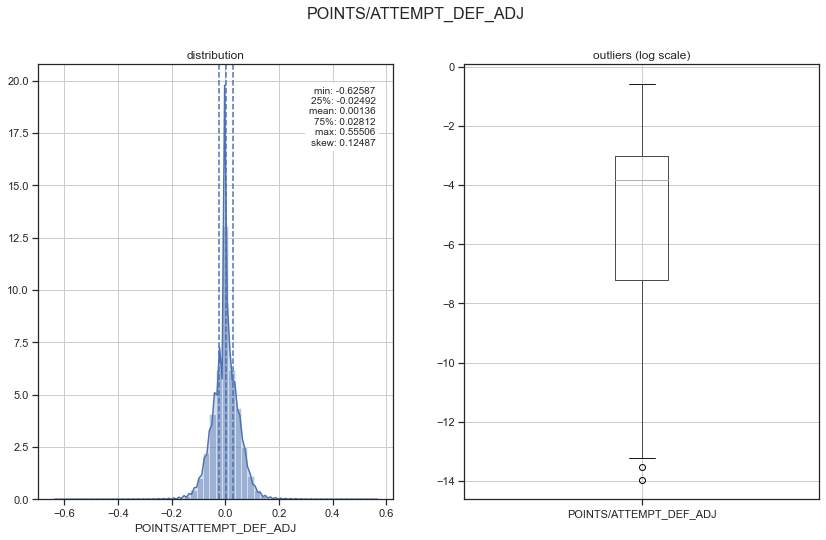

In [9]:
helpers.visualize_variable_distribution(boxscores, 'POINTS/ATTEMPT_DEF_ADJ', figsize=(14, 8))

In [10]:
boxscores['POINTS/ATTEMPT_HAT'] = boxscores['AVG_POINTS/ATTEMPT'] + boxscores['POINTS/ATTEMPT_DEF_ADJ']

In [11]:
pd.set_option('display.min_rows', 100)
display(boxscores.loc[boxscores['NAME'].isin(['Stephen Curry'])][['DATE', 'NAME', 'OPP_TEAM', 'ATTEMPTS', 'AVG_POINTS/ATTEMPT', 'POINTS/ATTEMPT_DEF_ADJ', 'POINTS/ATTEMPT_HAT', 'POINTS/ATTEMPT']].head(100))

DATE           NAME OPP_TEAM  ATTEMPTS  AVG_POINTS/ATTEMPT  \
370    2014-10-29  Stephen Curry      SAC     20.96                 NaN   
677    2014-11-01  Stephen Curry      LAL     22.52            1.145038   
946    2014-11-02  Stephen Curry      POR     21.52            1.264949   
1491   2014-11-05  Stephen Curry      LAC     20.64            1.169231   
2013   2014-11-08  Stephen Curry      HOU     19.88            1.214386   
2239   2014-11-09  Stephen Curry      PHX     21.76            1.307809   
2648   2014-11-11  Stephen Curry      SAS     18.88            1.304211   
2977   2014-11-13  Stephen Curry      BKN     12.88            1.245211   
3290   2014-11-15  Stephen Curry      CHA     15.44            1.251258   
3504   2014-11-16  Stephen Curry      LAL     21.20            1.249427   
4311   2014-11-21  Stephen Curry      UTA      9.00            1.267375   
4857   2014-11-23  Stephen Curry      OKC     16.76            1.250733   
5071   2014-11-25  Stephen Curry      MIA     22.96            1.223808   
5361   2014-11-26  Stephen Curry      ORL     15.20            1.272504   
5726   2014-11-28  Stephen Curry      CHA     23.08            1.305855   
5905   2014-11-30  Stephen Curry      DET     11.64            1.291213   
6392   2014-12-02  Stephen Curry      ORL     18.32            1.294509   
6775   2014-12-04  Stephen Curry      NOP     17.00            1.289023   
7136   2014-12-06  Stephen Curry      CHI     17.96            1.280184   
7507   2014-12-08  Stephen Curry      MIN     20.00            1.268700   
7793   2014-12-10  Stephen Curry      HOU     15.44            1.256801   
8475   2014-12-13  Stephen Curry      DAL     25.96            1.258354   
8691   2014-12-14  Stephen Curry      NOP     23.64            1.249389   
8994   2014-12-16  Stephen Curry      MEM     25.00            1.259708   
9310   2014-12-18  Stephen Curry      OKC     24.44            1.232410   
10158  2014-12-22  Stephen Curry      SAC     12.44            1.240458   
10477  2014-12-23  Stephen Curry      LAL     14.00            1.233519   
10546  2014-12-25  Stephen Curry      LAC     13.76            1.242822   
10868  2014-12-27  Stephen Curry      MIN     19.76            1.236884   
11456  2014-12-30  Stephen Curry      PHI      7.88            1.237916   
...           ...            ...      ...       ...                 ...   
26602  2015-03-28  Stephen Curry      MIL     14.32            1.259239   
27062  2015-03-31  Stephen Curry      LAC     18.08            1.264480   
27434  2015-04-02  Stephen Curry      PHX     22.88            1.267551   
27885  2015-04-04  Stephen Curry      DAL     13.32            1.266820   
28071  2015-04-05  Stephen Curry      SAS     17.88            1.262575   
28196  2015-04-07  Stephen Curry      NOP     18.88            1.263592   
28647  2015-04-09  Stephen Curry      POR     24.32            1.264397   
29014  2015-04-11  Stephen Curry      MIN     24.52            1.274260   
29472  2015-04-13  Stephen Curry      MEM     10.00            1.276135   
29883  2015-04-15  Stephen Curry      DEN     10.00            1.277649   
29963  2015-10-27  Stephen Curry      NOP     29.08                 NaN   
30503  2015-10-30  Stephen Curry      HOU     16.76            1.375516   
30750  2015-10-31  Stephen Curry      NOP     31.84            1.417976   
31246  2015-11-02  Stephen Curry      MEM     18.64            1.519053   
31506  2015-11-04  Stephen Curry      LAC     20.96            1.536545   
31857  2015-11-06  Stephen Curry      DEN     23.32            1.526262   
32148  2015-11-07  Stephen Curry      SAC     21.08            1.514936   
32467  2015-11-09  Stephen Curry      DET     20.64            1.465858   
32803  2015-11-11  Stephen Curry      MEM     24.08            1.420579   
33114  2015-11-12  Stephen Curry      MIN     28.52            1.390504   
33449  2015-11-14  Stephen Curry      BKN     32.32            1.417504   
33879  2015-11-17  Stephen Curry      